In [49]:
import pandas as pd
import numpy as np

In [50]:
df = pd.read_csv('final_dataset.csv')

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [52]:
scaler = StandardScaler()

In [53]:
# CSV 파일을 읽어들입니다.
df = pd.read_csv('final_dataset.csv')

# 특성과 레이블을 분리합니다.
X = df.drop('label', axis=1).values  # 특성 데이터
y = df['label'].values  # 레이블 데이터


# 훈련 세트와 나머지(검증+테스트) 세트로 분할합니다. (80% : 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = scaler.fit_transform(X_train)
X_temp = scaler.transform(X_temp)

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_temp = X_temp.reshape((X_temp.shape[0], 1, X_temp.shape[1]))

# 나머지 데이터를 검증 세트와 테스트 세트로 분할합니다. (50% : 50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 분할된 데이터 세트의 크기를 출력합니다.
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 분할된 데이터 세트의 레이블 분포를 출력합니다.
print(f"Train set label distribution: {np.bincount(y_train.astype(int))}")
print(f"Validation set label distribution: {np.bincount(y_val.astype(int))}")
print(f"Test set label distribution: {np.bincount(y_test.astype(int))}")

Train set: 1456 samples
Validation set: 182 samples
Test set: 183 samples
Train set label distribution: [1410   46]
Validation set label distribution: [176   6]
Test set label distribution: [177   6]


In [54]:
X_train.shape

(1456, 125)

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns


Accuracy: 0.9945

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       176
           1       1.00      0.83      0.91         6

    accuracy                           0.99       182
   macro avg       1.00      0.92      0.95       182
weighted avg       0.99      0.99      0.99       182



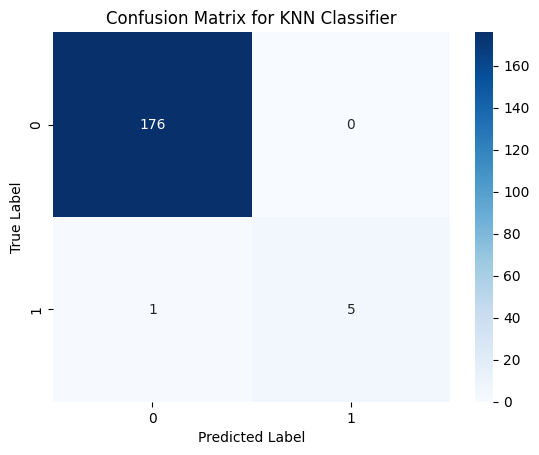

In [56]:
# KNN 모델 구성
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# 모델 학습
knn_classifier.fit(X_train, y_train)

# 검증 세트를 이용해 예측을 수행합니다.
y_pred = knn_classifier.predict(X_val)

# 정확도를 계산하고 출력합니다.
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 분류 리포트를 생성하고 출력합니다.
class_report = classification_report(y_val, y_pred)
print("\nClassification Report:")
print(class_report)

# 혼동 행렬을 생성하고 시각화합니다.
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

### **PyAudio Setup**

In [57]:
import pyaudio

In [58]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
SAMPLE_RATE = 16000
CHUNK = int(SAMPLE_RATE / 10)

audio = pyaudio.PyAudio()

In [59]:
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

In [62]:
import librosa

continue_recording = True

# def stop():
#     input("Press Enter to stop the recording:")
#     global continue_recording
#     continue_recording = False

def start_recording():

    stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=SAMPLE_RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    data = []
    
    global continue_recording
    continue_recording = True

    while continue_recording:
    
        audio_chunk = stream.read(CHUNK)
        data.append(audio_chunk)

        audio_int16 = np.frombuffer(audio_chunk, np.int16)
        audio_float32 = int2float(audio_int16)

        # Convert the audio to a suitable format for YAMnet
        waveform = np.frombuffer(audio_chunk, dtype=np.int16) / 32768.0
        waveform = waveform.astype(np.float32)
        
        # Extract Log Mel Spectrogram features
        spectrogram_features_list = []
        predictions = []

        n_fft_value = min(2048, len(waveform))

        spectrogram_features = librosa.feature.melspectrogram(y=waveform, sr=SAMPLE_RATE, n_fft=n_fft_value, n_mels=125)
        spectrogram_features = librosa.power_to_db(spectrogram_features, ref=np.max)
        spectrogram_features_list.append(spectrogram_features)
        spectrogram_aggregated = np.mean(spectrogram_features, axis=1).reshape(1, -1)

        # Ensure the feature count is correct
        if spectrogram_aggregated.shape[1] != scaler.n_features_in_:
            raise ValueError(f"Incorrect number of features. Expected {scaler.n_features_in_}, got {spectrogram_aggregated.shape[1]}")

        # Scale features
        spectrogram_scaled = scaler.transform(spectrogram_aggregated)

        # Inside your loop, after SVC prediction
        fall_detection_prediction = knn_classifier.predict(spectrogram_scaled)
        predictions.append(fall_detection_prediction)

        if fall_detection_prediction == 1:
            print("Fall Detected")
            break

In [67]:
start_recording()

Fall Detected
